<a href="https://colab.research.google.com/github/Subhas-1130/Subhas-demo/blob/main/002211001130_SUBHAS_CHANDRA_SHIT_ASSIGNMENT_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium -q

In [2]:
!pip install gym gym-legacy-toytext numpy==1.26.4

RL (Q-learning) for Mountain Car Problem

In [3]:
import gymnasium as gym
import numpy as np

env = gym.make('MountainCar-v0')

# Discretize
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

q_table = np.zeros((len(pos_space), len(vel_space), env.action_space.n))

learning_rate = 0.1
discount = 0.95
epochs = 2000
epsilon = 0.5
epsilon_decay = 0.998

def get_discrete_state(state):
    pos, vel = state
    pos_bin = np.digitize(pos, pos_space)
    vel_bin = np.digitize(vel, vel_space)
    return (pos_bin, vel_bin)

# Training loop
for epoch in range(epochs):
    state = get_discrete_state(env.reset()[0])
    terminated = False
    truncated = False

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}")

    while not terminated and not truncated:
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        new_state_continuous, reward, terminated, truncated, _ = env.step(action)
        new_state = get_discrete_state(new_state_continuous)

        done = terminated or truncated

        if not done:
            max_future_q = np.max(q_table[new_state])
            current_q = q_table[state + (action,)]

            new_q = current_q + learning_rate * (reward + discount * max_future_q - current_q)
            q_table[state + (action,)] = new_q

        elif terminated:
            q_table[state + (action,)] = 0

        state = new_state

    if epsilon > 0.05:
        epsilon *= epsilon_decay

print("Training finished!")
env.close()

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Training finished!


In [4]:
import imageio
import numpy as np
import gymnasium as gym

video_env = gym.make('MountainCar-v0', render_mode='rgb_array')

frames = []
state = get_discrete_state(video_env.reset()[0])
done = False

while not done:
    action = np.argmax(q_table[state])
    new_state_continuous, _, terminated, truncated, _ = video_env.step(action)
    state = get_discrete_state(new_state_continuous)
    done = terminated or truncated
    frame = video_env.render()
    frame = np.array(frame)
    if frame.ndim == 4 and frame.shape[0] == 2:
        frame = frame[0]
    frames.append(frame)

video_env.close()

h, w = frames[0].shape[:2]
frames = [f[:h, :w, :3] for f in frames]

# Save video
video_path = "mountaincar_RL.mp4"
imageio.mimsave(video_path, frames, fps=30, macro_block_size=None)
print(f"Video saved as: {video_path}")

Video saved as: mountaincar_RL.mp4


In [5]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done): # 'done' here means (terminated or truncated)
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 0.0005
UPDATE_EVERY = 4

env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

q_network_local = QNetwork(state_size, action_size).to(device)
q_network_target = QNetwork(state_size, action_size).to(device)
optimizer = optim.Adam(q_network_local.parameters(), lr=LR)
memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

q_network_target.load_state_dict(q_network_local.state_dict())

def learn(experiences, gamma):
    states, actions, rewards, next_states, dones = experiences

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    best_actions = q_network_local(next_states).detach().argmax(1).unsqueeze(1)
    q_targets_next = q_network_target(next_states).detach().gather(1, best_actions)
    q_targets = rewards + (gamma * q_targets_next * (1 - dones))
    q_expected = q_network_local(states).gather(1, actions)

    loss = nn.MSELoss()(q_expected, q_targets)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(q_network_local.parameters(), 1)
    optimizer.step()

    # Soft update
    for target_param, local_param in zip(q_network_target.parameters(), q_network_local.parameters()):
        target_param.data.copy_(0.01 * local_param.data + (1.0 - 0.01) * target_param.data)

# Training Loop
episodes = 1200
max_t = 1000
epsilon = 1.0
epsilon_decay = 0.997
epsilon_min = 0.01

scores = []
scores_window = deque(maxlen=100)

for i_episode in range(1, episodes + 1):
    state = env.reset()[0]
    score = 0

    for t in range(max_t):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        q_network_local.eval()
        with torch.no_grad():
            action_values = q_network_local(state_tensor)
        q_network_local.train()

        if random.random() > epsilon:
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(np.arange(action_size))

        next_state, reward, terminated, truncated, _ = env.step(action)

        # Reward shaping
        position, velocity = next_state
        reward = reward + 0.5 * abs(velocity) + (position + 0.5)
        done = terminated or truncated

        memory.add(state, action, reward, next_state, done)

        if len(memory) > BATCH_SIZE and t % UPDATE_EVERY == 0:
            experiences = memory.sample()
            learn(experiences, GAMMA)

        state = next_state
        score += reward
        if done:
            break

    scores_window.append(score)
    scores.append(score)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')

print('Training finished!')
env.close()

Using device: cuda
Episode 100	Average Score: -201.05
Episode 200	Average Score: -193.85
Episode 300	Average Score: -189.38
Episode 400	Average Score: -187.64
Episode 500	Average Score: -183.84
Episode 600	Average Score: -181.86
Episode 700	Average Score: -181.63
Episode 800	Average Score: -177.05
Episode 900	Average Score: -175.73
Episode 1000	Average Score: -166.41
Episode 1100	Average Score: -136.40
Episode 1200	Average Score: -132.15
Training finished!


In [6]:
import imageio

render_env = gym.make('MountainCar-v0', render_mode='rgb_array')

frames = []
state = render_env.reset()[0]
done = False

while not done:
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

    q_network_local.eval()
    with torch.no_grad():
        action_values = q_network_local(state_tensor)
    action = np.argmax(action_values.cpu().data.numpy())

    next_state, reward, terminated, truncated, _ = render_env.step(action)
    done = terminated or truncated

    frame = render_env.render()
    frames.append(frame)

    state = next_state

render_env.close()

# Save the video
video_path = "mountaincar_DRL.mp4"
imageio.mimsave(video_path, frames, fps=30, macro_block_size=None)
print(f"Video saved as: {video_path}")


Video saved as: mountaincar_DRL.mp4


RL (Q-learning) for Car Racing Problem

In [7]:
import gym
import gym_toytext
import numpy as np
import warnings

warnings.filterwarnings('ignore')

env = gym.make("Roulette-v0")

num_actions = env.action_space.n
q_table = np.zeros(num_actions)

learning_rate = 0.1
discount = 0.9
epochs = 50_000
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01

for epoch in range(epochs):
    env.reset()

    # Epsilon-greedy action selection
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table)

    new_state, reward, done, info = env.step(action)

    # Update Q-table
    current_q = q_table[action]
    new_q = current_q + learning_rate * (reward - current_q)
    q_table[action] = new_q

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

env.close()

print("\n Training finished!")
print("Final Q-values (expected reward for each bet):")
print(q_table.round(4))

best_action = np.argmax(q_table)
print(f"\nBest bet to make: Action {best_action} (Expected reward: {q_table[best_action]:.2f})")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



 Training finished!
Final Q-values (expected reward for each bet):
[-0.9185 -0.0409 -0.3946 -0.0317 -0.2569 -0.305  -0.0139 -0.1205 -0.3994
 -0.1247 -0.3436 -0.0539 -0.0254 -0.1875 -0.3355 -0.3776 -0.0069 -0.3189
 -0.393  -0.0934 -0.1242 -0.3255 -0.2867 -0.0539 -0.0688 -0.5292 -0.0826
 -0.1652 -0.4557 -0.3851 -0.1282 -0.0286 -0.3526 -0.3268 -0.2437 -0.0675
 -0.1586  0.    ]

Best bet to make: Action 37 (Expected reward: 0.00)


RL (Q-learning) for Roulette

In [8]:
import gym
import gym_toytext
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

env = gym.make("Roulette-v0")
state_size = 1
action_size = env.action_space.n

# Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = QNetwork(state_size, action_size).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Replay buffer
memory = deque(maxlen=5000)
batch_size = 64

episodes = 50000
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.9999

# Training loop
for ep in range(episodes):
    env.reset()
    state = np.array([0.0], dtype=np.float32)
    done = False

    # Epsilon-greedy
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state).unsqueeze(0).to(device)
            action = torch.argmax(q_network(state_tensor)).item()

    # Take action
    next_state, reward, done, info = env.step(action)
    next_state = np.array([0.0], dtype=np.float32)

    # Store in replay memory
    memory.append((state, action, reward, next_state, done))

    if len(memory) >= batch_size:
        batch = random.sample(memory, batch_size)
        states_b, actions_b, rewards_b, next_states_b, dones_b = zip(*batch)

        states_b = torch.tensor(np.array(states_b), dtype=torch.float32).to(device)
        next_states_b = torch.tensor(np.array(next_states_b), dtype=torch.float32).to(device)
        actions_b = torch.tensor(np.array(actions_b)).unsqueeze(1).to(device)
        rewards_b = torch.tensor(np.array(rewards_b), dtype=torch.float32).unsqueeze(1).to(device)
        dones_b = torch.tensor(np.array(dones_b), dtype=torch.float32).unsqueeze(1).to(device)

        # Compute Q targets
        q_values = q_network(states_b).gather(1, actions_b)
        with torch.no_grad():
            q_next = q_network(next_states_b).max(1)[0].unsqueeze(1)
            q_target = rewards_b + gamma * q_next * (1 - dones_b)

        # Update network
        loss = criterion(q_values, q_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

env.close()

with torch.no_grad():
    state_tensor = torch.tensor([[0.0]], dtype=torch.float32).to(device)
    final_qs = q_network(state_tensor).cpu().numpy()[0]

print("\n DRL Training finished!")
print("Final Q-values (expected reward for each bet):")
print(final_qs.round(4))
best_action = np.argmax(final_qs)
print(f"\n Best bet to make: Action {best_action} (Expected reward: {final_qs[best_action]:.2f})")



 DRL Training finished!
Final Q-values (expected reward for each bet):
[-7.526e-01  7.320e-02 -2.185e-01  1.074e-01  3.140e-02  2.392e-01
  1.048e-01  4.070e-02  1.104e-01  2.184e-01  2.188e-01  1.985e-01
  1.685e-01  2.327e-01  1.209e-01  2.117e-01 -7.460e-02  1.998e-01
  2.171e-01 -3.480e-01  2.016e-01  1.559e-01  2.399e-01 -1.023e-01
 -1.393e-01  1.302e-01 -5.224e-01  1.861e-01  1.768e-01  1.720e-02
  2.556e-01  2.442e-01  1.490e-01  1.400e-01 -9.700e-03 -8.640e-02
  1.580e-01  3.000e-04]

 Best bet to make: Action 30 (Expected reward: 0.26)


In [9]:
import numpy as np

# 1. Define the graph structure using an adjacency matrix
# Example: A 5-node graph
# Nodes are indexed from 0 to N-1
# float('inf') represents no direct connection
# Diagonal elements are 0 (cost from a node to itself)

graph_matrix = np.array([
    [0,   1,   5,   float('inf'), float('inf')],  # Node 0
    [float('inf'), 0,   2,   8,   float('inf')],  # Node 1
    [float('inf'), float('inf'), 0,   1,   3],   # Node 2
    [float('inf'), float('inf'), float('inf'), 0,   4],   # Node 3
    [float('inf'), float('inf'), float('inf'), float('inf'), 0]    # Node 4
])

# 2. Specify the start and end nodes
start_node = 0
end_node = 4

# 3. Define reward function parameters
# Negative reward for each step equal to the edge weight
# Positive reward for reaching the goal node
# Large negative reward for invalid moves

goal_reward = 100
invalid_move_penalty = -100

print("Graph Adjacency Matrix:")
print(graph_matrix)
print(f"\nStart Node: {start_node}")
print(f"End Node: {end_node}")
print(f"Goal Reward: {goal_reward}")
print(f"Invalid Move Penalty: {invalid_move_penalty}")

Graph Adjacency Matrix:
[[ 0.  1.  5. inf inf]
 [inf  0.  2.  8. inf]
 [inf inf  0.  1.  3.]
 [inf inf inf  0.  4.]
 [inf inf inf inf  0.]]

Start Node: 0
End Node: 4
Goal Reward: 100
Invalid Move Penalty: -100


DRL Implementation using DQN

In [10]:
import random

# 1. Determine the number of states (nodes) and actions
num_states = graph_matrix.shape[0]
num_actions = graph_matrix.shape[1]

print(f"Number of states (nodes): {num_states}")
print(f"Number of actions per state: {num_actions}")

# 2. Initialize the Q-table
# Initialize with zeros. For shortest path, negative Q-values are expected for costs.
q_table = np.zeros((num_states, num_actions))
# Alternatively, could initialize with small random numbers or a very large negative number if we want to ensure exploration initially.
# q_table = np.random.uniform(low=-1.0, high=1.0, size=(num_states, num_actions))

print(f"Q-table initialized with shape: {q_table.shape}")

# 3. Create a function for epsilon-greedy action selection
def choose_action(current_state, epsilon, graph_matrix, q_table):
    valid_actions = np.where(graph_matrix[current_state, :] != float('inf'))[0]
    if len(valid_actions) == 0:
        return -1 # Indicate no valid actions

    if random.uniform(0, 1) < epsilon: # Explore
        action = random.choice(valid_actions)
    else: # Exploit
        # Select action with max Q-value among valid actions
        q_values_for_state = q_table[current_state, :]
        # Filter for valid actions only
        valid_q_values = q_values_for_state[valid_actions]
        max_q_value = np.max(valid_q_values)

        # Handle multiple actions with the same max Q-value
        best_valid_actions = valid_actions[np.where(valid_q_values == max_q_value)[0]]
        action = random.choice(best_valid_actions)
    return action

# 4. Create a function to calculate the reward
def get_reward(current_state, action, end_node, graph_matrix, goal_reward, invalid_move_penalty):
    if action == end_node:
        return goal_reward

    cost = graph_matrix[current_state, action]
    if cost == float('inf'):
        return invalid_move_penalty
    else:
        return -cost # Negative reward for step cost

print("Epsilon-greedy action selection function 'choose_action' created.")
print("Reward calculation function 'get_reward' created.")

# 5. Define the Q-learning update rule parameters
learning_rate = 0.8 # Alpha (α) - how much new information overrides old information
discount_factor = 0.95 # Gamma (γ) - importance of future rewards

print(f"Q-learning learning rate (alpha): {learning_rate}")
print(f"Q-learning discount factor (gamma): {discount_factor}")

Number of states (nodes): 5
Number of actions per state: 5
Q-table initialized with shape: (5, 5)
Epsilon-greedy action selection function 'choose_action' created.
Reward calculation function 'get_reward' created.
Q-learning learning rate (alpha): 0.8
Q-learning discount factor (gamma): 0.95


Q-learning Implementation for Shortest Path

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque # For experience replay buffer

# 1. Define the Neural Network for DQN
# Input: current state (one-hot encoded vector of size num_states)
# Output: Q-value for each possible action (size num_actions)

class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = self.relu(x)
        q_values = self.fc2(x)
        return q_values

print("DQNAgent neural network class defined.")


DQNAgent neural network class defined.


In [12]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # state and next_state should be numerical representations, not one-hot encoded yet
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None # Not enough samples to form a batch
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.bool)
        )

    def __len__(self):
        return len(self.buffer)

print("ReplayBuffer class defined.")

ReplayBuffer class defined.


DRL (DQN) for Shortest Path in Graph

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Initialize the main DQN network and a separate target DQN network
policy_net = DQNAgent(num_states, num_actions).to(device)
target_net = DQNAgent(num_states, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copy weights from policy_net to target_net
target_net.eval() # Set target network to evaluation mode

print(f"Policy Network initialized. Device: {device}")
print(f"Target Network initialized. Weights copied from policy_net and set to eval mode. Device: {device}")

# 5. Define the optimizer and the loss function
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
criterion = nn.MSELoss() # Mean Squared Error Loss

print("Optimizer (Adam) and Loss function (MSELoss) defined.")


Policy Network initialized. Device: cuda
Target Network initialized. Weights copied from policy_net and set to eval mode. Device: cuda
Optimizer (Adam) and Loss function (MSELoss) defined.


In [14]:
def choose_action_dqn(current_state, epsilon, num_actions, policy_net, device):
    if random.uniform(0, 1) < epsilon: # Explore
        # Choose a random action (node index)
        action = random.randrange(num_actions)
    else: # Exploit
        # Convert current_state to a one-hot encoded tensor and move to device
        state_tensor = torch.zeros(1, num_states).to(device)
        state_tensor[0, current_state] = 1.0

        with torch.no_grad(): # No gradient calculation needed for action selection
            q_values = policy_net(state_tensor)
        action = q_values.argmax(dim=1).item() # Select action with max Q-value
    return action

print("DQN-specific 'choose_action_dqn' function defined for epsilon-greedy action selection.")


DQN-specific 'choose_action_dqn' function defined for epsilon-greedy action selection.


Training Q-learning agent for 2000 episodes.
Max steps per episode: 25
Epsilon: initial=1.0, min=0.01, decay_rate=0.005
Episode 200/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 400/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 600/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 800/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 1000/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 1200/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 1400/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 1600/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 1800/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100
Episode 2000/2000 - Total Reward: 95.00 - Path Length: 3 - Epsilon: 0.0100

Q-learning training complete.

Evaluating learned Q-table for optimal path:
  Optimal path found by Q-learning: [0, 2, 4]
  Total cos

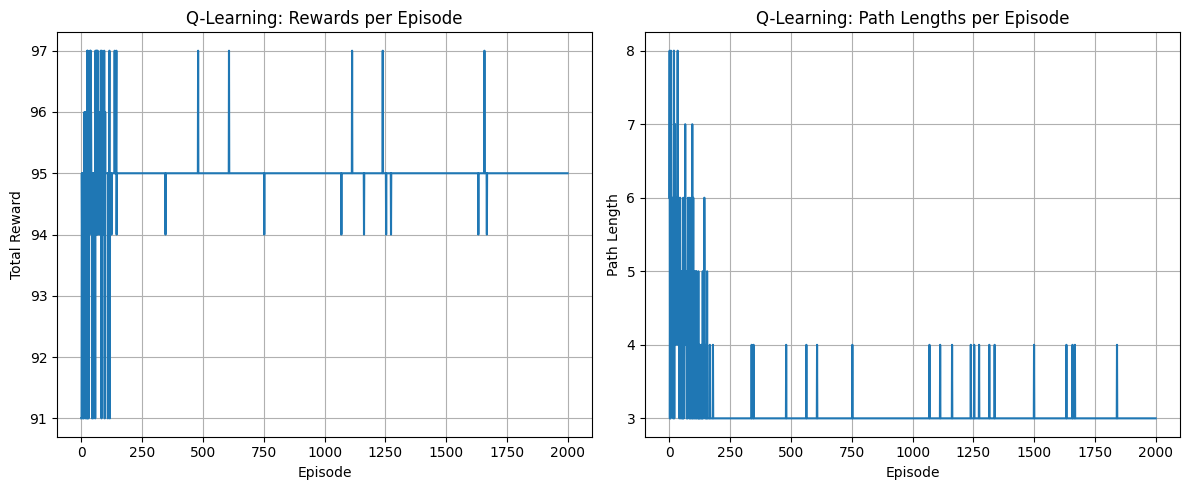

Final Q-table:
[[ 85.5         87.35        90.           0.           0.        ]
 [  0.          88.34906771  93.          87.           0.        ]
 [  0.           0.          95.          94.         100.        ]
 [  0.           0.           0.          95.         100.        ]
 [  0.           0.           0.           0.           0.        ]]


In [15]:
import matplotlib.pyplot as plt

# 1. Define training parameters
num_episodes = 2000
max_steps_per_episode = num_states * num_states # A generous upper bound to prevent infinite loops

initial_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.005 # Rate at which epsilon decays per episode

epsilon = initial_epsilon

print(f"Training Q-learning agent for {num_episodes} episodes.")
print(f"Max steps per episode: {max_steps_per_episode}")
print(f"Epsilon: initial={initial_epsilon}, min={min_epsilon}, decay_rate={epsilon_decay_rate}")

# 2. Initialize lists to store metrics
rewards_per_episode = []
path_lengths_per_episode = []

# 3. Implement the main training loop
for episode in range(num_episodes):
    current_state = start_node
    done = False
    episode_reward = 0
    episode_path = [start_node]

    for step in range(max_steps_per_episode):
        action = choose_action(current_state, epsilon, graph_matrix, q_table)

        if action == -1: # No valid actions from current_state
            episode_reward += invalid_move_penalty # Penalize for being stuck/invalid state
            break

        # Determine next state (action is the next node index)
        next_state = action

        # Calculate reward for taking this action
        reward = get_reward(current_state, action, end_node, graph_matrix, goal_reward, invalid_move_penalty)
        episode_reward += reward
        episode_path.append(next_state)

        # Calculate max Q-value for the next state
        # Ensure we only consider valid actions from the next_state
        valid_actions_next_state = np.where(graph_matrix[next_state, :] != float('inf'))[0]
        if len(valid_actions_next_state) > 0:
            max_future_q = np.max(q_table[next_state, valid_actions_next_state])
        else:
            max_future_q = 0 # No future rewards if stuck or end state

        # Q-learning update rule
        q_table[current_state, action] = q_table[current_state, action] + learning_rate * \
                                         (reward + discount_factor * max_future_q - q_table[current_state, action])

        current_state = next_state

        if current_state == end_node:
            done = True
            break

    # After each episode, decay epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)

    # Store metrics
    rewards_per_episode.append(episode_reward)
    path_lengths_per_episode.append(len(episode_path))

    if (episode + 1) % 200 == 0:
        print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {episode_reward:.2f} - Path Length: {len(episode_path)} - Epsilon: {epsilon:.4f}")

print("\nQ-learning training complete.")

# 4. Evaluate the learned Q-table to find the optimal path
print("\nEvaluating learned Q-table for optimal path:")
optimal_path = [start_node]
current_eval_state = start_node
total_path_cost = 0
total_path_reward = 0

for _ in range(max_steps_per_episode):
    # Choose action with max Q-value (greedy policy)
    q_values_current_state = q_table[current_eval_state, :]

    # Filter for valid actions from current_eval_state
    valid_actions_eval = np.where(graph_matrix[current_eval_state, :] != float('inf'))[0]

    if len(valid_actions_eval) == 0:
        print(f"  Stuck at node {current_eval_state} - no valid moves. Path: {optimal_path}")
        break

    # Select action with max Q-value among valid actions
    max_q_value_eval = np.max(q_values_current_state[valid_actions_eval])
    best_eval_actions = valid_actions_eval[np.where(q_values_current_state[valid_actions_eval] == max_q_value_eval)[0]]

    next_eval_node = random.choice(best_eval_actions) # Choose randomly if multiple best actions

    if current_eval_state == end_node:
        break # Reached the goal

    # Accumulate cost and reward
    cost = graph_matrix[current_eval_state, next_eval_node]
    if cost != float('inf'): # Should always be a valid move if chosen correctly
        total_path_cost += cost
        total_path_reward += -cost # Step reward

    optimal_path.append(next_eval_node)
    current_eval_state = next_eval_node

    if current_eval_state == end_node:
        total_path_reward += goal_reward # Add goal reward at the end
        break

print(f"  Optimal path found by Q-learning: {optimal_path}")
print(f"  Total cost of optimal path (sum of edge weights): {total_path_cost:.2f}")
print(f"  Total reward for optimal path (using reward function): {total_path_reward:.2f}")

# Visualize training convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode)
plt.title('Q-Learning: Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(path_lengths_per_episode)
plt.title('Q-Learning: Path Lengths per Episode')
plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Final Q-table:")
print(q_table)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque # For experience replay buffer

# DQNAgent, ReplayBuffer, policy_net, target_net, optimizer, criterion, choose_action_dqn, num_states, num_actions, graph_matrix, start_node, end_node, goal_reward, invalid_move_penalty, device are already defined in previous cells.

# 1. Define training parameters specific to the DQN agent
dqn_num_episodes = 2000 # Number of training episodes
dqn_max_steps_per_episode = num_states * num_states # A generous upper bound

dqn_initial_epsilon = 1.0 # Initial exploration rate
dqn_min_epsilon = 0.01    # Minimum exploration rate
dqn_epsilon_decay_rate = 0.005 # Rate at which epsilon decays per episode

dqn_batch_size = 64       # Number of transitions to sample from replay buffer
dqn_gamma = 0.95          # Discount factor for future rewards
dqn_learning_rate = 0.001 # Learning rate for the optimizer (already set in optimizer def)

target_update_frequency = 10 # How often to update the target network (in episodes)

print(f"DQN Training Parameters:")
print(f"  Episodes: {dqn_num_episodes}")
print(f"  Max Steps per Episode: {dqn_max_steps_per_episode}")
print(f"  Epsilon: initial={dqn_initial_epsilon}, min={dqn_min_epsilon}, decay_rate={dqn_epsilon_decay_rate}")
print(f"  Batch Size: {dqn_batch_size}")
print(f"  Discount Factor (Gamma): {dqn_gamma}")
print(f"  Learning Rate: {dqn_learning_rate}")
print(f"  Target Network Update Frequency: {target_update_frequency} episodes")

# Initialize Replay Buffer
replay_buffer = ReplayBuffer(capacity=10000)
print(f"Replay Buffer initialized with capacity {replay_buffer.capacity}.")

DQN Training Parameters:
  Episodes: 2000
  Max Steps per Episode: 25
  Epsilon: initial=1.0, min=0.01, decay_rate=0.005
  Batch Size: 64
  Discount Factor (Gamma): 0.95
  Learning Rate: 0.001
  Target Network Update Frequency: 10 episodes
Replay Buffer initialized with capacity 10000.


In [17]:
def optimize_model():
    if len(replay_buffer) < dqn_batch_size:
        return # Not enough samples to train

    transitions = replay_buffer.sample(dqn_batch_size)
    if transitions is None:
        return # Not enough samples to form a batch

    # Unpack the batch and convert to tensors on the correct device
    states, actions, rewards, next_states, dones = transitions

    # One-hot encode states and next_states
    states_one_hot = torch.zeros(dqn_batch_size, num_states, device=device)
    states_one_hot.scatter_(1, states.unsqueeze(1).long().to(device), 1.0)

    next_states_one_hot = torch.zeros(dqn_batch_size, num_states, device=device)
    next_states_one_hot.scatter_(1, next_states.unsqueeze(1).long().to(device), 1.0)

    actions = actions.to(device) # Actions are indices, don't one-hot encode here
    rewards = rewards.to(device)
    dones = dones.to(device)

    # Compute Q(s_t, a) - the model predicts Q(s_t), then we select the
    # columns of actions taken.
    current_q_values = policy_net(states_one_hot).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for next_states are computed based on the target_net
    # This is where the double DQN concept applies (though simple DQN uses policy_net for max(Q') here)
    with torch.no_grad():
        # Filter out states that are 'done'
        next_state_q_values = target_net(next_states_one_hot)
        # For shortest path, valid actions are those with finite cost in graph_matrix
        # We need to ensure we only consider Q-values for valid actions in next_states
        # This is more complex than a simple filter due to batching.
        # For now, let's assume all actions are valid, or simplify this for graph traversal
        # A more robust approach would involve masking invalid actions with -inf before taking max

        # Mask invalid actions for next states (if needed - currently we don't have this in DQN's choose_action)
        # For now, we will simply take the max Q-value from the target network for the next state
        max_next_q_values = next_state_q_values.max(1)[0]
        # Set max_next_q_values to 0 for terminal states
        max_next_q_values[dones] = 0.0

    # Compute the expected Q values: R + gamma * max(Q(s', a'))
    expected_q_values = rewards + dqn_gamma * max_next_q_values

    # Compute loss
    loss = criterion(current_q_values, expected_q_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Clip gradients to prevent exploding gradients
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


Starting DQN training for 2000 episodes...
Episode 200/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 400/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 600/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 800/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 1000/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 1200/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 1400/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 1600/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 1800/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100
Episode 2000/2000 - Total Reward: 100.00 - Path Length: 2 - Epsilon: 0.0100

DQN training complete.

Evaluating learned DQN policy for optimal path:
  Stuck at node 0 - DQN chose an invalid move. Path: [0]
  Optimal path found by DQN: [0]
  Total cost of optimal path (sum of 

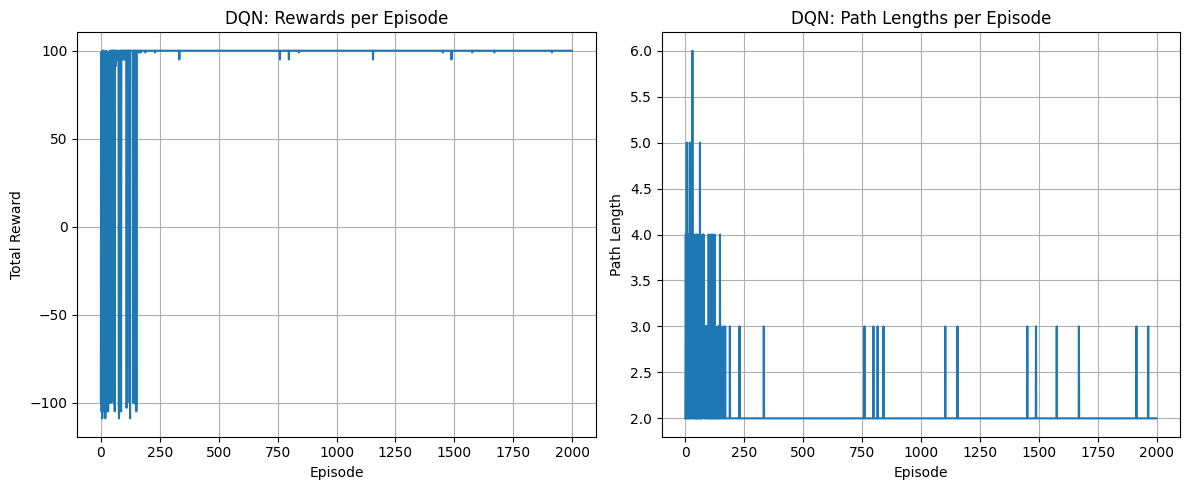

DQNAgent(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

In [18]:
import matplotlib.pyplot as plt

# 3. Implement the main training loop for the DQN agent
dqn_rewards_per_episode = []
dqn_path_lengths_per_episode = []
dqn_epsilon = dqn_initial_epsilon

print(f"\nStarting DQN training for {dqn_num_episodes} episodes...")

for episode in range(dqn_num_episodes):
    current_state = start_node
    episode_reward = 0
    episode_path = [start_node]
    done = False

    # Convert current_state to one-hot for choose_action_dqn
    current_state_tensor = torch.zeros(1, num_states).to(device)
    current_state_tensor[0, current_state] = 1.0

    for step in range(dqn_max_steps_per_episode):
        # Select action using epsilon-greedy policy with DQN
        action = choose_action_dqn(current_state, dqn_epsilon, num_actions, policy_net, device)

        # Determine next state and reward
        next_state = action # For graph traversal, action is typically the next node
        reward = get_reward(current_state, action, end_node, graph_matrix, goal_reward, invalid_move_penalty)

        episode_reward += reward
        episode_path.append(next_state)

        # Check if the episode ended (reached end_node or invalid move)
        if next_state == end_node or reward == invalid_move_penalty: # If invalid move, it's considered done for this step
            done = True

        # Store the transition in the replay buffer
        # Store states as integers, optimize_model will convert to one-hot
        replay_buffer.add(current_state, action, reward, next_state, done)

        # Move to the next state
        current_state = next_state

        # Perform one optimization step (on the policy network)
        optimize_model()

        if done:
            break

    # Decay epsilon
    dqn_epsilon = max(dqn_min_epsilon, dqn_epsilon - dqn_epsilon_decay_rate)

    # Store metrics
    dqn_rewards_per_episode.append(episode_reward)
    dqn_path_lengths_per_episode.append(len(episode_path))

    # Update the target network periodically
    if (episode + 1) % target_update_frequency == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if (episode + 1) % 200 == 0:
        print(f"Episode {episode + 1}/{dqn_num_episodes} - Total Reward: {episode_reward:.2f} - Path Length: {len(episode_path)} - Epsilon: {dqn_epsilon:.4f}")

print("\nDQN training complete.")

# 4. Evaluate the trained DQN agent
print("\nEvaluating learned DQN policy for optimal path:")
optimal_path_dqn = [start_node]
current_eval_state_dqn = start_node
total_path_cost_dqn = 0
total_path_reward_dqn = 0

# Set policy_net to evaluation mode
policy_net.eval()

with torch.no_grad():
    for _ in range(dqn_max_steps_per_episode):
        state_tensor_eval = torch.zeros(1, num_states).to(device)
        state_tensor_eval[0, current_eval_state_dqn] = 1.0

        # Get Q-values from the policy network (greedy action selection)
        q_values_eval = policy_net(state_tensor_eval)
        action_eval = q_values_eval.argmax(dim=1).item() # Select action with max Q-value

        # Check for valid action in graph matrix, similar to Q-learning evaluation
        if graph_matrix[current_eval_state_dqn, action_eval] == float('inf'):
            # If the chosen action is invalid, break and report.
            print(f"  Stuck at node {current_eval_state_dqn} - DQN chose an invalid move. Path: {optimal_path_dqn}")
            total_path_reward_dqn += invalid_move_penalty # Penalize final path if stuck
            break

        if current_eval_state_dqn == end_node:
            total_path_reward_dqn += goal_reward # Add goal reward at the end if it reached
            break

        # Accumulate cost and reward
        cost = graph_matrix[current_eval_state_dqn, action_eval]
        total_path_cost_dqn += cost
        total_path_reward_dqn += -cost # Step reward

        optimal_path_dqn.append(action_eval)
        current_eval_state_dqn = action_eval

        if current_eval_state_dqn == end_node:
            total_path_reward_dqn += goal_reward # Add goal reward at the end
            break

print(f"  Optimal path found by DQN: {optimal_path_dqn}")
print(f"  Total cost of optimal path (sum of edge weights): {total_path_cost_dqn:.2f}")
print(f"  Total reward for optimal path (using reward function): {total_path_reward_dqn:.2f}")

# 5. Visualize DQN training convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(dqn_rewards_per_episode)
plt.title('DQN: Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(dqn_path_lengths_per_episode)
plt.title('DQN: Path Lengths per Episode')
plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.grid(True)

plt.tight_layout()
plt.show()

# Set policy_net back to training mode if further training is planned
policy_net.train()

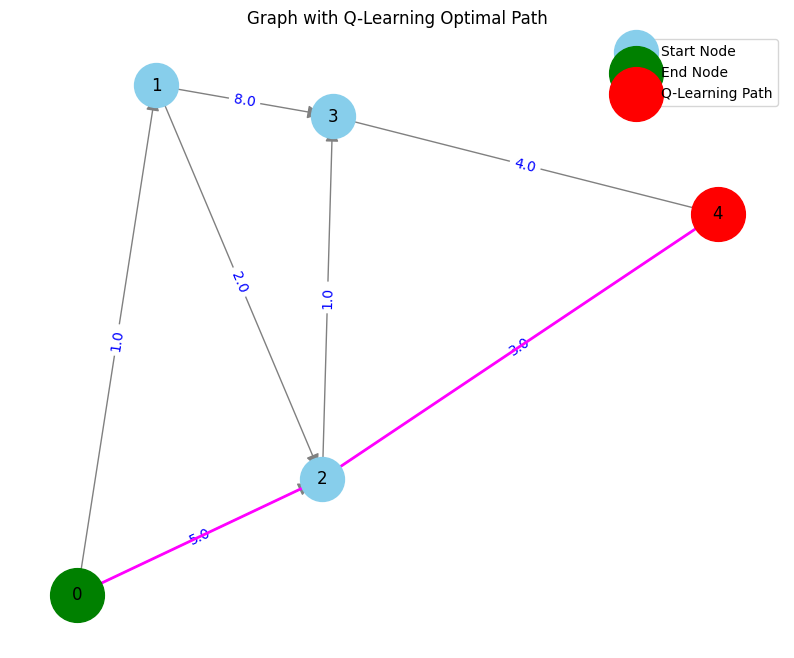

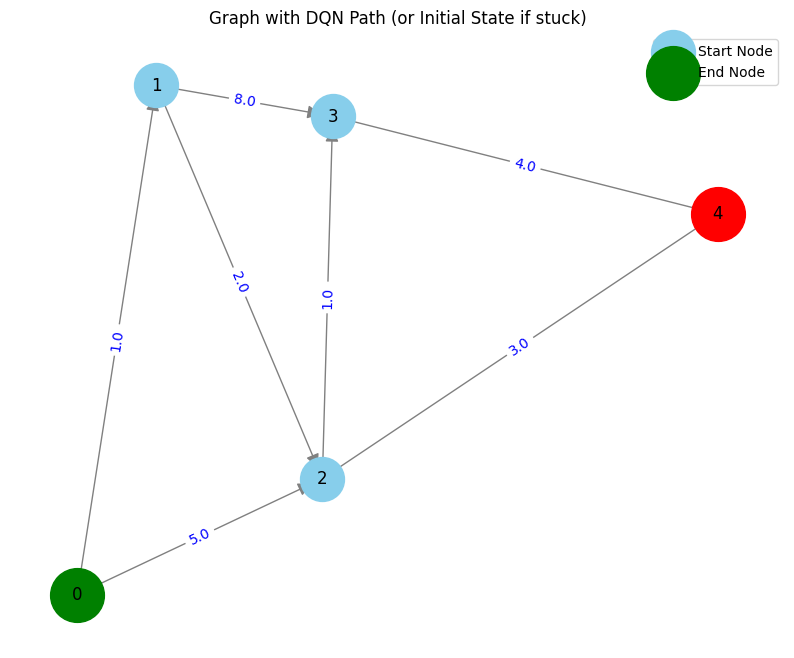

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Visualize the input graph and the shortest path found by Q-learning

# Create a directed graph from the adjacency matrix
G = nx.DiGraph()
num_nodes = graph_matrix.shape[0]

for i in range(num_nodes):
    G.add_node(i)

for i in range(num_nodes):
    for j in range(num_nodes):
        weight = graph_matrix[i, j]
        if weight != 0 and weight != float('inf'): # Add edges only if there's a connection
            G.add_edge(i, j, weight=weight)


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42) # For consistent layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)

# Highlight start and end nodes
nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green', node_size=1500, label='Start Node')
nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color='red', node_size=1500, label='End Node')

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=20)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')


# Highlight the Q-learning optimal path
q_path_edges = []
for i in range(len(optimal_path) - 1):
    q_path_edges.append((optimal_path[i], optimal_path[i+1]))

nx.draw_networkx_edges(G, pos, edgelist=q_path_edges, edge_color='magenta', width=2, label='Q-Learning Path')

plt.title('Graph with Q-Learning Optimal Path')
plt.legend(['Start Node', 'End Node', 'Q-Learning Path'])
plt.axis('off')
plt.show()


# 2. Visualize the graph and the path found by DQN agent
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)

# Highlight start and end nodes
nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green', node_size=1500, label='Start Node')
nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color='red', node_size=1500, label='End Node')

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=20)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Draw edge labels (weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

# Highlight the DQN optimal path (or lack thereof)
dqn_path_edges = []
# Check if DQN found a path with more than one node
if len(optimal_path_dqn) > 1:
    for i in range(len(optimal_path_dqn) - 1):
        dqn_path_edges.append((optimal_path_dqn[i], optimal_path_dqn[i+1]))
    nx.draw_networkx_edges(G, pos, edgelist=dqn_path_edges, edge_color='orange', width=2, label='DQN Path')
elif optimal_path_dqn[0] == start_node and len(optimal_path_dqn) == 1:
    # If DQN got stuck at the start node, indicate this visually if possible
    # For simplicity, we just won't draw a path, and the title will reflect it
    pass # No path to draw

plt.title('Graph with DQN Path (or Initial State if stuck)')
plt.legend(['Start Node', 'End Node', 'DQN Path'] if len(optimal_path_dqn) > 1 else ['Start Node', 'End Node'])
plt.axis('off')
plt.show()

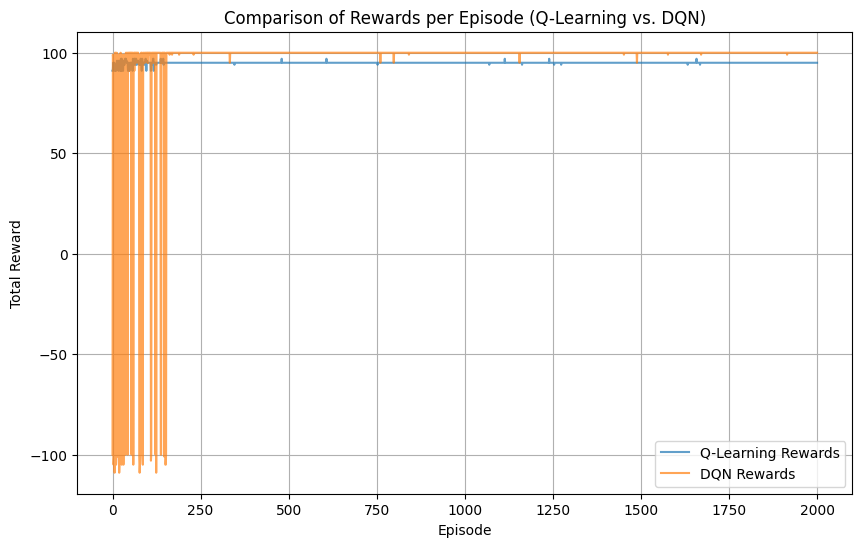

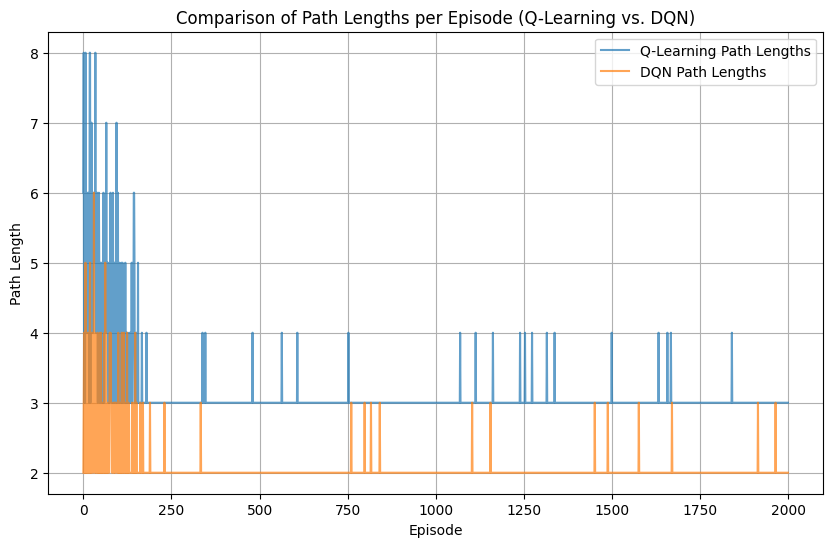

In [20]:
import matplotlib.pyplot as plt

# 6. Generate a single plot comparing the 'Rewards per Episode' for both Q-learning and DQN agents.
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Q-Learning Rewards', alpha=0.7)
plt.plot(dqn_rewards_per_episode, label='DQN Rewards', alpha=0.7)
plt.title('Comparison of Rewards per Episode (Q-Learning vs. DQN)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# 7. Generate a single plot comparing the 'Path Lengths per Episode' for both Q-learning and DQN agents.
plt.figure(figsize=(10, 6))
plt.plot(path_lengths_per_episode, label='Q-Learning Path Lengths', alpha=0.7)
plt.plot(dqn_path_lengths_per_episode, label='DQN Path Lengths', alpha=0.7)
plt.title('Comparison of Path Lengths per Episode (Q-Learning vs. DQN)')
plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.legend()
plt.grid(True)
plt.show()